# Project: Investigate the Gapminder Africa Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This analysis will look into three datasets of the gapminder foundation (Gapminder.org).
Although many countries are represented in the dataset, I will focus on countries in Africa. I chose this focus as I do not know very much about Africa and would like to get to know it at least by the numbers.

The datasets are the following:
 -  Income per Person (GDP per Capita)
 -  Children per woman
 -  Mortality rate of newborns
 -  Countries in Africa (For data cleaning purposes only)
 
All datasets have data for each country and each year.
The analysis will look at the development of each dataset over the years and will graphically compare the developments. 

Core questions are:
 - How does the GDP per Capita change for African countries
     - By how much percent did each country increase/decrease?
     - Which countries had the largest gain and which countries the smallest?
 - Is there a correlation between the mortality rate of newborns and the GDP?
     - How big is the difference between the winners and the losers of GDP growth?
 - How does the mortality rate affect the children per woman?
     - Is there a correclation between the mortality rate and the children per woman?
     - How do the three variables GDP, mortality rate and children per woman effect each other?
    

In [144]:
# Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

### General Properties
First the four datasets are loaded and inspected for their shape and if their countries match

In [239]:
# Gross domestic product dataframe
gdp = pd.read_csv("income_per_person_gdppercapita_ppp_inflation_adjusted.csv")
# Children per woman (cpw) dataframe
cpw = pd.read_csv("children_per_woman_total_fertility.csv")
# Child mortality rate (cmr) dataframe
cmr = pd.read_csv("child_mortality_0_5_year_olds_dying_per_1000_born.csv")
# Countries with the according continent (from GitHub)
c2c = pd.read_csv("continent_to_country.csv")

#### Inspect

In [240]:
cpw.shape, cmr.shape, gdp.shape

((184, 220), (193, 220), (193, 242))

In [241]:
gdp.head(1)

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Afghanistan,603,603,603,603,603,603,603,603,603,...,2420,2470,2520,2580,2640,2700,2760,2820,2880,2940


In [242]:
cpw.head(1)

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,6.04,5.82,5.6,5.38,5.17,4.98,4.8,4.64,4.48,4.33


#### Adjust columns
The three dataframes neither match in row nor column count.
In a first effort the columns of the gdp dataset are omitted, since they forecast into the future.

The rowcount is depending on the countries represented in the dataframes. Before they are being aligned, all datasets are reduced to African-only countries. Maybe the missing countries are all non-African.

In [243]:
# Getting rid of the predictions in the GDP dataset and keeping only the years until 2018:
gdp.drop(gdp.columns[list(np.arange(220,242))], axis=1, inplace = True)
print(list(gdp.columns) == list(cpw.columns))
print(list(cmr.columns) == list(cpw.columns))
# Now all columns match

True
True


#### Create African countries list
Now that the columns are the same for all dataframes, the countries will be reduced to African countries only.
The dataset with the African countries is inspected, and some country names are adjusted, since they do not match the names in the dataframe.

Afterwards a list is created, which contains all the African countries.

In [208]:
c2c.head(1)

,Continent,Country,Column,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,Africa,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
# Get a list of the African countries
c2c.query('Continent == "Africa"', inplace = True)

# Adjust country names so they are the same for all datasets
old_names = ["Burkina",
    "Congo",
    "Congo, Democratic Republic of",
    "Ivory Coast"]
new_names = ["Burkina Faso",
    "Congo, Rep.",
    "Congo, Dem. Rep.",
    "Cote d'Ivoire"]

# Change the names
for i, match in enumerate(old_names):  
    c2c.loc[c2c["Country"] == match] = new_names[i]
    
# Create a list of African countries
african_countries = list(c2c.Country)
len(set(african_countries))
# The African country list seems to be complete

54

#### Reduce dataframe rows
Now each country in each dataframe is checked whether it is an African country. If not, the row is deleted.

In [210]:
# Matching all datasets against the list of African countries to reduce them to Africa
for df in [gdp, cpw, cmr]:
    for match in df.country:
        if match not in african_countries:
            # If the country is not in Africa the country is dropped
            df.drop(df.index[df['country'] == match], inplace = True)
# Check if the datasets have been successfully reduced to Africa
cmr.shape, gdp.shape, cpw.shape        

((54, 220), (54, 220), (54, 220))

#### Check value types of the dataframes
Now that all dataframes have the same shape and matching rows and columns the values are inspected.
First it is checked wheather each cell has a value and in a second step if they are all floats (ints for the gdp dataset). 

In [211]:
# Checking if any values are missing
cpw.isnull().any(axis=1).sum(), gdp.isnull().any(axis=1).sum(), cmr.isnull().any(axis=1).sum()

(0, 0, 0)

In [212]:
# Use the countryname as the index
cpw.set_index('country', inplace = True)
gdp.set_index('country', inplace = True)
cmr.set_index('country', inplace = True)

In [225]:
# Check if all datatypes are correct
cpw.dtypes.all(), gdp.dtypes.all(), cmr.dtypes.all()

(dtype('float64'), dtype('int64'), dtype('float64'))

#### To make sure to have correct values each dataframe gets plotted
 - Children per woman: The max value of each year.
 - Child mortality rate: The max value of each year.
 - GDP: The max value for each year.

All graphs look like they are in reasonable areas. There are some odd spikes in the child mortality dataset, but without getting to far into the exploration of the data, it makes sense that single events can have a big impact on the mortality rate in one year. If one country suffers a big catastrophe, it makes sense that the child mortality rate spikes. This is directly visible in the graph as the worst value for each year is plotted.

##### Max children per woman

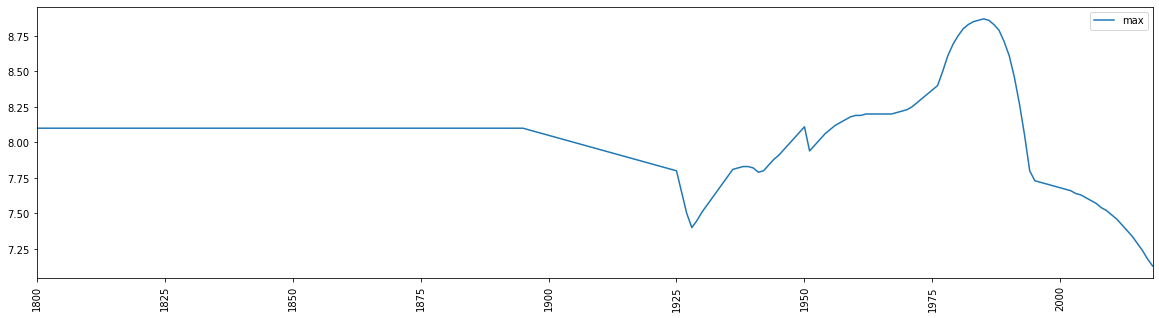

In [269]:
max_values = cpw.describe().loc["max"]
pd.DataFrame(max_values).plot.line(rot= 90, figsize= (20,5));

##### Max child mortality rate (0 to 5 year olds dying per 1000 born)

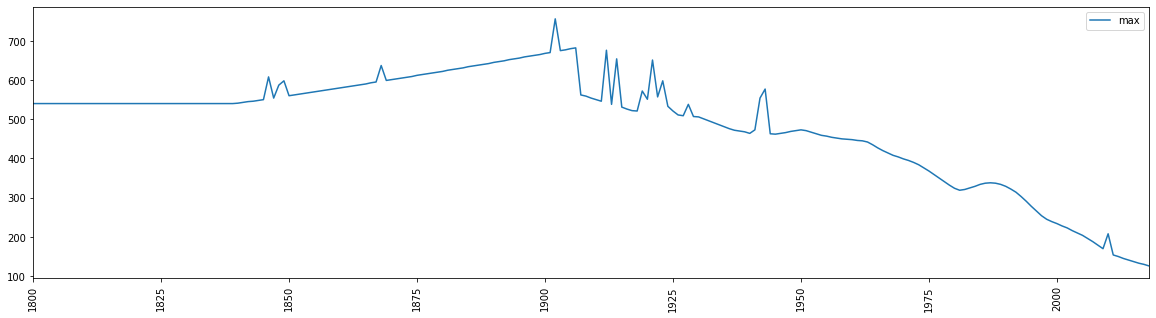

In [268]:
max_values = cmr.describe().loc["max"]
pd.DataFrame(max_values).plot.line(rot= 90, figsize= (20,5));

##### Max GDP

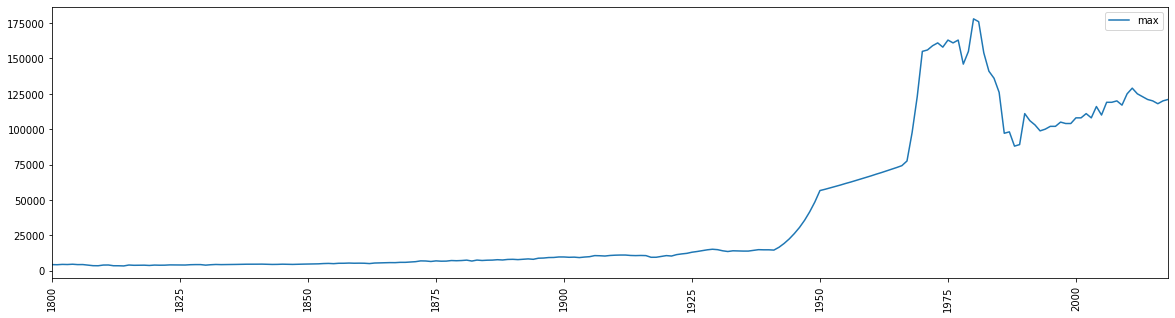

In [274]:
max_values = gdp.describe().loc["max"]
pd.DataFrame(max_values).plot.line(rot= 90, figsize= (20,5));

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!